## Random Forest Classifier - Balanced Learning

### Setup & Utilities

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

import warnings 
warnings.filterwarnings("ignore")

from ast import literal_eval

In [2]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cfm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

In [3]:
from sklearn.metrics import roc_curve,auc

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

## Import Dataset

In [4]:
df = pd.read_csv('../data/alldata-balanced-cleaned.zip', compression='zip')
data = 'tokenized_stemmed'
target = 'toxicity'

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram,toxicity
0,144abb9156acc835,"""\nFor what it's worth, I suggest you refrain ...",0,0,0,0,0,0,for what it is worth i suggest you refrain fr...,"['for', 'what', 'it', 'is', 'worth', 'i', 'sug...","['worth', 'suggest', 'refrain', 'pushing', 'so...","['worth', 'suggest', 'refrain', 'push', 'sock'...","[('worth', 'JJ'), ('suggest', 'JJS'), ('refrai...","['worth', 'suggest', 'refrain', 'pushing', 'so...","['worth', 'suggest', 'refrain', 'push', 'sock'...","[('worth', 'suggest'), ('suggest', 'refrain'),...",0
1,d4d3e9ee9facbe91,I have noticed you STILL haven't responded? I ...,0,0,0,0,0,0,i have noticed you still have not responded i ...,"['i', 'have', 'noticed', 'you', 'still', 'have...","['noticed', 'still', 'responded', 'file', 'for...","['notic', 'still', 'respond', 'file', 'formal'...","[('noticed', 'VBN'), ('still', 'RB'), ('respon...","['noticed', 'still', 'responded', 'file', 'for...","['notice', 'still', 'respond', 'file', 'formal...","[('noticed', 'still'), ('still', 'responded'),...",0
2,da223e53f7097ea6,"::The statement at the lead of the article, 'T...",0,0,0,0,0,0,the statement at the lead of the article the b...,"['the', 'statement', 'at', 'the', 'lead', 'of'...","['statement', 'lead', 'article', 'bedrock', 'c...","['statement', 'lead', 'articl', 'bedrock', 'ce...","[('statement', 'NN'), ('lead', 'NN'), ('articl...","['statement', 'lead', 'article', 'bedrock', 'c...","['statement', 'lead', 'article', 'bedrock', 'c...","[('statement', 'lead'), ('lead', 'article'), (...",0
3,53d465a2cca996d7,"""\n\nan FYI\nI understand completely why you d...",0,0,0,0,0,0,an fyi i understand completely why you delete...,"['an', 'fyi', 'i', 'understand', 'completely',...","['fyi', 'understand', 'completely', 'deleted',...","['fyi', 'understand', 'complet', 'delet', 'sec...","[('fyi', 'NN'), ('understand', 'VBP'), ('compl...","['fyi', 'understand', 'completely', 'deleted',...","['fyi', 'understand', 'completely', 'delete', ...","[('fyi', 'understand'), ('understand', 'comple...",0
4,96c840eda4dc9ee7,"interestingly, if you go look at Eek's talk pa...",0,0,0,0,0,0,interestingly if you go look at eeks talk page...,"['interestingly', 'if', 'you', 'go', 'look', '...","['interestingly', 'go', 'look', 'eeks', 'talk'...","['interestingli', 'go', 'look', 'eek', 'talk',...","[('interestingly', 'RB'), ('go', 'VB'), ('look...","['interestingly', 'go', 'look', 'eeks', 'talk'...","['interestingly', 'go', 'look', 'eeks', 'talk'...","[('interestingly', 'go'), ('go', 'look'), ('lo...",0


In [6]:
df[target].value_counts()

0    22468
1    22468
Name: toxicity, dtype: int64

## Split Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[data], df[target], test_size=0.30, random_state=42, stratify=df[target]) 
X_train = X_train.apply(lambda x: literal_eval(x))
X_test = X_test.apply(lambda x: literal_eval(x))

In [8]:
print(f"Training set\n{y_train.value_counts()}\n")
print(f"Test set\n{y_test.value_counts()}\n")

Training set
1    15728
0    15727
Name: toxicity, dtype: int64

Test set
0    6741
1    6740
Name: toxicity, dtype: int64



## Random Forest Classifier

#### No Parameters Tuning

In [11]:
rf_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=5, max_features=15000, analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()) ])

rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(analyzer=<function <lambda> at 0x7f7c550c2820>,
                                 max_features=15000, min_df=5)),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [12]:
y_pred = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      6741
           1       0.91      0.83      0.87      6740

    accuracy                           0.87     13481
   macro avg       0.88      0.87      0.87     13481
weighted avg       0.88      0.87      0.87     13481



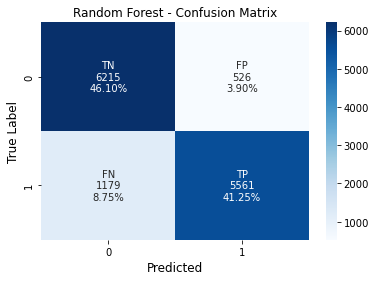

In [13]:
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 'Random Forest - Confusion Matrix')

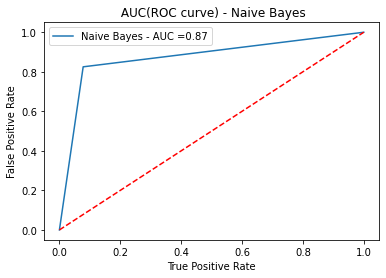

In [14]:
plot_roc_curve(y_test, y_pred, 'Random Forest')

#### Parameters Tuning

In [18]:
rf_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=5, max_features=15000, analyzer=lambda x: x)),  
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()) ])

In [19]:
rf_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__bootstrap', 'clf__ccp_alpha', 'clf__class_weight', 'clf__criterion', 'clf__max_depth', 'clf__max_features', 'clf__max_leaf_nodes', 'clf__max_samples', 'clf__min_impurity_decrease', 'clf__min_impurity_split', 'clf__min_samples_leaf', 'clf__min_samples_split', 'clf__min_weight_fraction_leaf', 'clf__n_estimators', 'clf__n_jobs', 'clf__oob_score', 'clf__random_state', 'clf__verbose', 'clf__warm_start'])

In [20]:
params = {'vect__ngram_range': [(1, 1), (1, 2)],
          'tfidf__use_idf': (True, False),
          'clf__criterion': ["gini","entropy"],
          'clf__min_samples_split':[2,3,5,7,10]
         }

In [21]:
gs = GridSearchCV(estimator=rf_pipeline, param_grid=params, n_jobs=-1, cv=4)
gs_results = gs.fit(X_train, y_train)

In [22]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'clf__criterion': 'gini', 'clf__min_samples_split': 5, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}
accuracy: 0.8714035924336353


#### Retrain and test the model

In [23]:
rf_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=5, max_features=15000, analyzer=lambda x: x,ngram_range=(1, 1))),  
    ('tfidf', TfidfTransformer(use_idf=False)),  
    ('clf', RandomForestClassifier(criterion="gini",min_samples_split=5 )) ])

In [24]:
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(analyzer=<function <lambda> at 0x7f7c567df040>,
                                 max_features=15000, min_df=5)),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', RandomForestClassifier(min_samples_split=5))])

In [25]:
y_pred = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      6741
           1       0.91      0.83      0.87      6740

    accuracy                           0.88     13481
   macro avg       0.88      0.88      0.88     13481
weighted avg       0.88      0.88      0.88     13481



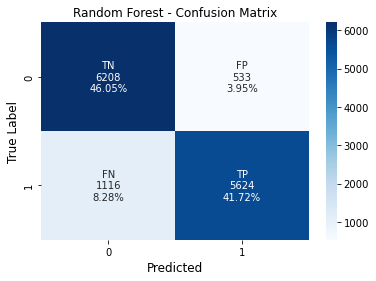

In [26]:
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 'Random Forest - Confusion Matrix')

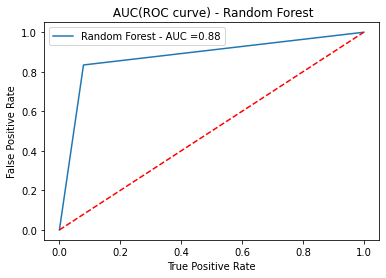

In [27]:
plot_roc_curve(y_test, y_pred, 'Random Forest')